# InceptionV3:





Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10


5/5 [==============================] - 8s 1s/step - loss: 8.2496 - accuracy: 0.3312 - val_loss: 6.6554 - val_accuracy: 0.2812
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 5.6185 - accuracy: 0.3766 - val_loss: 3.0974 - val_accuracy: 0.2812
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 3.6562 - accuracy: 0.3701 - val_loss: 2.5404 - val_accuracy: 0.4375
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 2.6393 - accuracy: 0.4026 - val_loss: 2.4554 - val_accuracy: 0.4688
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 2.6857 - accuracy: 0.4675 - val_loss: 3.9142 - val_accuracy: 0.3438
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 2.4275 - accuracy: 0.4416 - val_loss: 2.1843 - val_accuracy: 0.3125
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 1.8109 - accuracy: 0.4

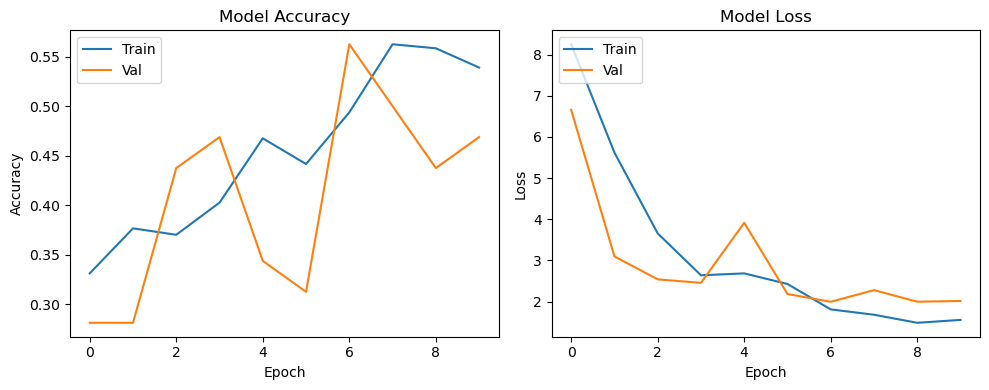

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.applications import InceptionV3

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Adjusted for InceptionV3

# Reset the model
tf.keras.backend.clear_session()

# Load InceptionV3 base model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(3, activation='softmax')  # Assuming 3 classes as per your setup
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 21868451 (83.42 MB)
Trainable params: 65667 (256.51 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [7]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step - loss: 2.5110 - accuracy: 0.4375
Test accuracy: 0.4375


# ResNet-152:

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import layers, models

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()

# Load ResNet152 as the base model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

234698864/234698864 [==============================] - 18s 0us/step
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 33s 6s/step - loss: 1.9905 - accuracy: 0.4156 - val_loss: 1.3351 - val_accuracy: 0.4375
Epoch 2/10
5/5 [==============================] - 27s 6s/step - loss: 1.3796 - accuracy: 0.5649 - val_loss: 0.9947 - val_accuracy: 0.6562
Epoch 3/10
5/5 [==============================] - 27s 6s/step - loss: 1.3861 - accuracy: 0.5909 - val_loss: 0.9595 - val_accuracy: 0.5938
Epoch 4/10
5/5 [==============================] - 27s 6s/step - loss: 0.9094 - accuracy: 0.6364 - val_loss: 1.0803 - val_accuracy: 0.5625
Epoch 5/10
5/5 [==============================] - 27s 6s/step - loss: 0.7446 - accuracy: 0.6818 - val_loss: 0.9761 - val_accuracy: 0.6250
Epoch 6/10
5/5 [==============================] - 27s 6s/step - loss: 0.5650 - accuracy: 0.7987 - val_loss: 1.0288 - val_accuracy: 0.5938
Epoch 7/10
5/5 [=======

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 16, 16, 2048)      58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 59421571 (226.68 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 58370944 (222.67 MB)
________

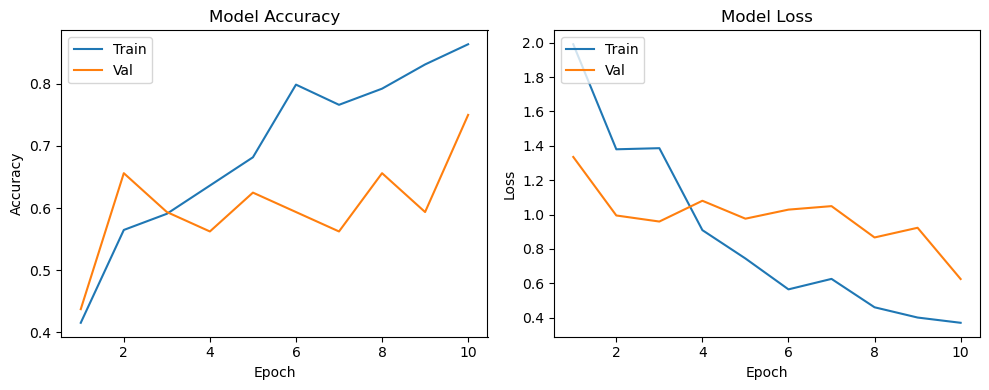

In [11]:
num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 5s 5s/step - loss: 0.6520 - accuracy: 0.7500
Test accuracy: 0.75


# VGG19:

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()

# Load VGG19 as the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

80134624/80134624 [==============================] - 6s 0us/step
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 29s 6s/step - loss: 2.2090 - accuracy: 0.3313 - val_loss: 1.2904 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 27s 6s/step - loss: 1.6455 - accuracy: 0.4091 - val_loss: 1.0303 - val_accuracy: 0.5312
Epoch 3/10
5/5 [==============================] - 27s 6s/step - loss: 1.3105 - accuracy: 0.5130 - val_loss: 0.9637 - val_accuracy: 0.4062
Epoch 4/10
5/5 [==============================] - 27s 6s/step - loss: 1.0532 - accuracy: 0.5714 - val_loss: 1.3091 - val_accuracy: 0.4375
Epoch 5/10
5/5 [==============================] - 27s 6s/step - loss: 1.0172 - accuracy: 0.6234 - val_loss: 0.8844 - val_accuracy: 0.6250
Epoch 6/10
5/5 [==============================] - 27s 6s/step - loss: 0.7433 - accuracy: 0.6753 - val_loss: 0.7888 - val_accuracy: 0.5625
Epoch 7/10
5/5 [==========

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
___________

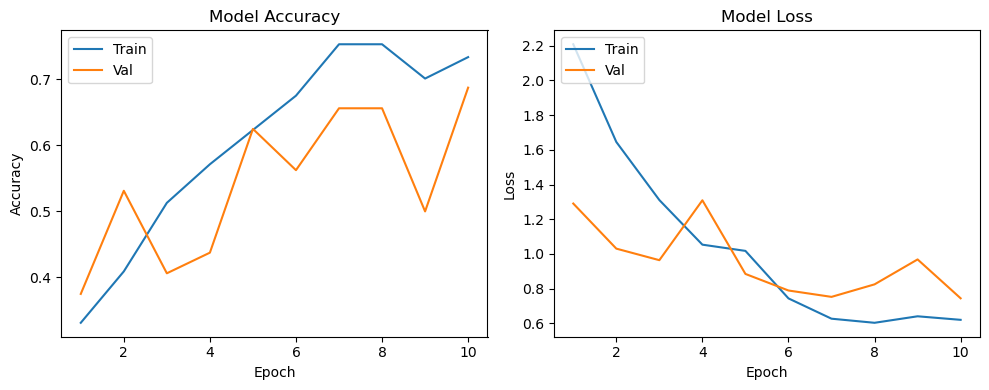

In [15]:
num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 5s 5s/step - loss: 0.6604 - accuracy: 0.6875
Test accuracy: 0.6875


# EM-Net++:

In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()
model = models.Sequential()

# Add EM-Net++ layers
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 100s 19s/step - loss: 252.7618 - accuracy: 0.3636 - val_loss: 1907067.1250 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 94s 19s/step - loss: 177.8476 - accuracy: 0.3896 - val_loss: 10789854.0000 - val_accuracy: 0.4688
Epoch 3/10
5/5 [==============================] - 96s 19s/step - loss: 57.5787 - accuracy: 0.5584 - val_loss: 17020232.0000 - val_accuracy: 0.2812
Epoch 4/10
5/5 [==============================] - 95s 19s/step - loss: 41.6467 - accuracy: 0.6429 - val_loss: 13058032.0000 - val_accuracy: 0.3125
Epoch 5/10
5/5 [==============================] - 92s 19s/step - loss: 25.5191 - accuracy: 0.6364 - val_loss: 9708684.0000 - val_accuracy: 0.3125
Epoch 6/10
5/5 [==============================] - 99s 21s/step - loss: 31.3364 - accuracy: 0.7403 - val_loss: 4527590.5000 - val_accuracy: 0.3438
Epoch 7/10
5/5 [=====================

# DenseNet:

In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121  # Import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add additional dense layer
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and custom layers to create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)


29084464/29084464 [==============================] - 3s 0us/step
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 47s 7s/step - loss: 2.2219 - accuracy: 0.4351 - val_loss: 7.8741 - val_accuracy: 0.2812
Epoch 2/10
5/5 [==============================] - 31s 7s/step - loss: 1.4125 - accuracy: 0.3961 - val_loss: 211.0931 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 31s 7s/step - loss: 1.1046 - accuracy: 0.4286 - val_loss: 466.6449 - val_accuracy: 0.2188
Epoch 4/10
5/5 [==============================] - 31s 6s/step - loss: 1.0358 - accuracy: 0.4481 - val_loss: 572.4601 - val_accuracy: 0.3750
Epoch 5/10
5/5 [==============================] - 31s 6s/step - loss: 0.8798 - accuracy: 0.5649 - val_loss: 985.9376 - val_accuracy: 0.3438
Epoch 6/10
5/5 [==============================] - 31s 6s/step - loss: 0.8109 - accuracy: 0.6494 - val_loss: 836.1213 - val_accuracy: 0.3438
Epoch 7/10
5/5 [

# NASNet:

In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.applications import NASNetLarge

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Load NASNetLarge pre-trained model
base_model = NASNetLarge(include_top=False, input_shape=input_shape, weights='imagenet')

# Freeze base model layers
base_model.trainable = False

# Create custom model on top of NASNetLarge
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    verbose=1  # Set verbose to 1 to see the training progress
)

343610240/343610240 [==============================] - 24s 0us/step
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 39s 7s/step - loss: 1.7186 - accuracy: 0.4625 - val_loss: 1.5215 - val_accuracy: 0.3438
Epoch 2/10
5/5 [==============================] - 27s 6s/step - loss: 1.4293 - accuracy: 0.3896 - val_loss: 1.2077 - val_accuracy: 0.2812
Epoch 3/10
5/5 [==============================] - 27s 5s/step - loss: 1.1777 - accuracy: 0.4351 - val_loss: 1.1174 - val_accuracy: 0.5312
Epoch 4/10
5/5 [==============================] - 28s 6s/step - loss: 1.2592 - accuracy: 0.3313 - val_loss: 1.1756 - val_accuracy: 0.4375
Epoch 5/10
5/5 [==============================] - 28s 6s/step - loss: 1.1047 - accuracy: 0.4437 - val_loss: 0.9245 - val_accuracy: 0.6250
Epoch 6/10
5/5 [==============================] - 27s 6s/step - loss: 1.0077 - accuracy: 0.5195 - val_loss: 0.9871 - val_accuracy: 0.5312
Epoch 7/10
5/5 [=======

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 16, 16, 4032)      84916818  
                                                                 
 global_average_pooling2d_1  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               1032448   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 85950037 (327.87 MB)
Trainable params: 1033219 (3.94 MB)
Non-trainable params: 84916818 (323.93 MB)
______

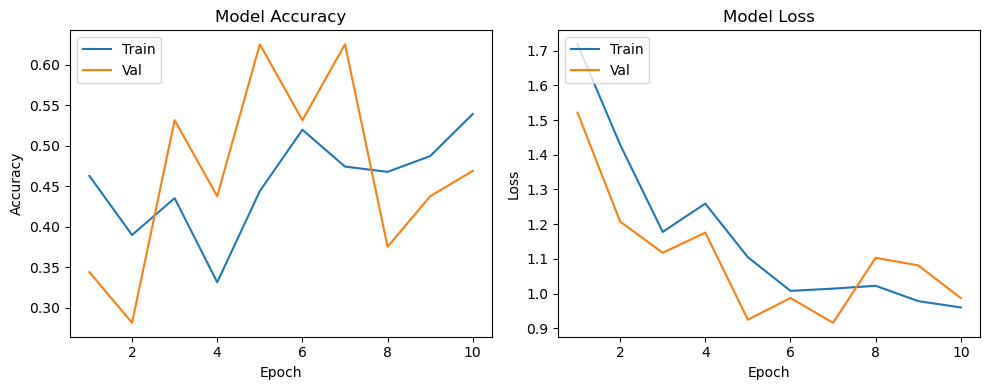

In [23]:
num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 5s 5s/step - loss: 1.0106 - accuracy: 0.4062
Test accuracy: 0.40625


# MobileNetV3 Large:

In [26]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.applications import MobileNetV3Large

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()

# Load MobileNetV3 Large model without including the top layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Create custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

12683000/12683000 [==============================] - 1s 0us/step
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 5s 788ms/step - loss: 3.4818 - accuracy: 0.4026 - val_loss: 3.0899 - val_accuracy: 0.4375
Epoch 2/10
5/5 [==============================] - 3s 611ms/step - loss: 2.9974 - accuracy: 0.5130 - val_loss: 2.6722 - val_accuracy: 0.6562
Epoch 3/10
5/5 [==============================] - 3s 600ms/step - loss: 2.6691 - accuracy: 0.6299 - val_loss: 2.6693 - val_accuracy: 0.5938
Epoch 4/10
5/5 [==============================] - 3s 629ms/step - loss: 2.4365 - accuracy: 0.6104 - val_loss: 2.4838 - val_accuracy: 0.5312
Epoch 5/10
5/5 [==============================] - 3s 610ms/step - loss: 2.2244 - accuracy: 0.6753 - val_loss: 2.2219 - val_accuracy: 0.5938
Epoch 6/10
5/5 [==============================] - 3s 606ms/step - loss: 2.0462 - accuracy: 0.7078 - val_loss: 2.0193 - val_accuracy: 0.6562
Epoch 7/10
5/5

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 16, 16, 960)       2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3119747 (11.90 MB)
Trainable params: 12339

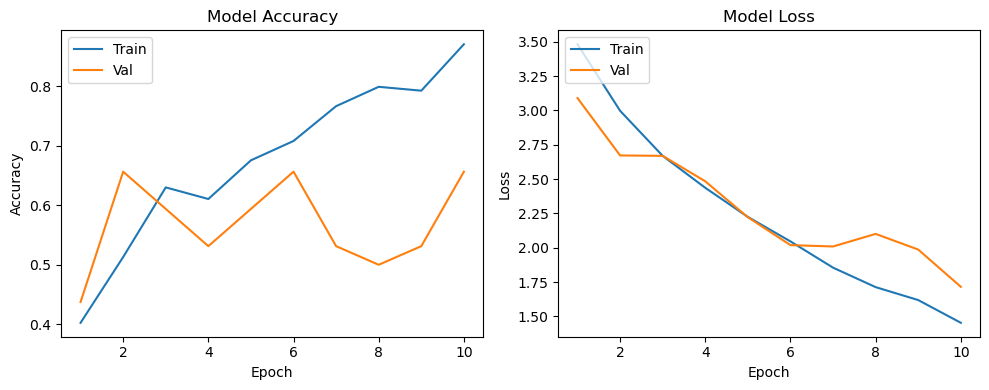

In [28]:
num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 1s 620ms/step - loss: 1.5949 - accuracy: 0.7812
Test accuracy: 0.78125
